In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os
import json
import sys
import numpy as np
sys.path.append("..")
import copy
from tqdm.auto import tqdm

In [3]:
from src import models, data, operators, utils, functional, metrics, lens
from src.utils import logging_utils, experiment_utils
import logging
import torch
import baukit
import random
import numpy as np
import torch
experiment_utils.set_seed(123456)

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format = logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout
)

In [4]:
#################################################
h_layer = 7
beta = 0.4
n_training = 10
#################################################

In [5]:
mt = models.load_model(name = "gptj", fp16 = True, device = "cuda")

2023-06-23 16:38:49 src.models INFO     loading EleutherAI/gpt-j-6B (device=cuda, fp16=True)


In [6]:
relation = data.load_dataset().filter(relation_names=["work location"])[0].set(prompt_templates=[" {}:"])
train, test = relation.split(n_training)

In [7]:
icl_prompt = functional.make_prompt(
    prompt_template = train.prompt_templates[0],
    subject = "{}",
    examples = train.samples,
    mt = mt
)
print(icl_prompt)

<|endoftext|> pharmacist: pharmacy
 fashion designer: studio
 secretary: office
 baker: bakery
 doctor: hospital
 mechanic: garage
 teacher: school
 researcher: laboratory
 pilot: airplane
 chef: kitchen
 {}:


In [8]:
test = functional.filter_relation_samples_based_on_provided_fewshots(
    mt = mt, 
    test_relation=test,
    prompt_template = icl_prompt,
    batch_size=4
)
len(test.samples)

17

In [9]:
estimator = operators.JacobianIclMeanEstimator(
    mt = mt, h_layer=h_layer, beta=beta
)
operator = estimator(train)

In [10]:
for sample in test.samples:
    pred = operator(sample.subject).predictions[:3]
    print(f"{sample} | pred: {[f'{p.token} ({p.prob:.2f})' for p in pred]}")

accountant -> office | pred: [' office (0.84)', ' business (0.06)', ' bank (0.01)']
barber -> barbershop | pred: [' clinic (0.29)', ' shop (0.18)', ' salon (0.08)']
farmer -> farm | pred: [' farm (0.48)', ' garden (0.10)', ' agricultural (0.04)']
firefighter -> fire station | pred: [' office (0.09)', ' fire (0.07)', ' hospital (0.03)']
hairdresser -> salon | pred: [' office (0.13)', ' shop (0.12)', ' clinic (0.08)']
lawyer -> courthouse | pred: [' office (0.85)', ' law (0.03)', ' business (0.01)']
librarian -> library | pred: [' library (0.83)', ' school (0.04)', ' office (0.02)']
musician -> concert hall | pred: [' studio (0.60)', ' music (0.07)', ' theater (0.03)']
nurse -> hospital | pred: [' hospital (0.86)', ' clinic (0.05)', ' nursing (0.02)']
photographer -> studio | pred: [' studio (0.79)', ' office (0.08)', ' art (0.01)']
salesperson -> store | pred: [' office (0.35)', ' shop (0.18)', ' store (0.04)']
scientist -> laboratory | pred: [' laboratory (0.70)', ' lab (0.20)', ' rese

In [11]:
imaginary_operators = []
for interpolate_on in tqdm(range(2, 8)):
    estimator_i = operators.JacobianIclMeanEstimator_Imaginary(
        mt = mt, h_layer=7, beta=1, interpolate_on=interpolate_on, n_trials=8
    )
    operator_i = estimator_i(train)
    imaginary_operators.append(operator_i)
    # print("---------------------------------------------------")

  0%|          | 0/6 [00:00<?, ?it/s]

---------------------------------------------------
---------------------------------------------------
---------------------------------------------------
---------------------------------------------------
---------------------------------------------------
---------------------------------------------------


In [12]:
operator.weight.norm().item(), operator.bias.norm().item()

(24.25, 282.5)

Text(0.5, 0, 'n_points')

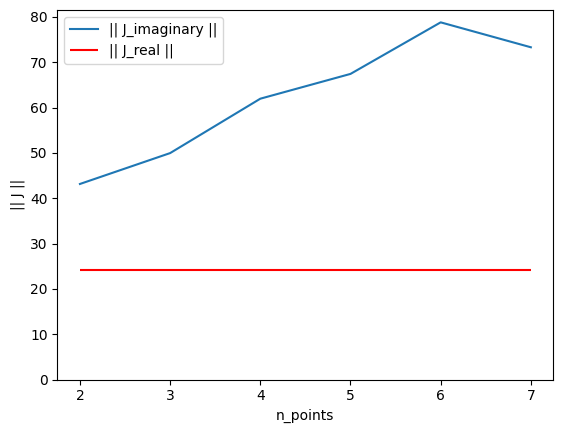

In [13]:
w_norms = [op.weight.norm().item() for op in imaginary_operators]
plt.plot(range(2, 8), w_norms, label = "|| J_imaginary ||")
plt.hlines(operator.weight.norm().item(), 2, 7, color="red", label = "|| J_real ||")
plt.ylim(bottom=0)
plt.legend()
plt.ylabel("|| J ||")
plt.xlabel("n_points")

In [18]:
operator_dict = imaginary_operators[1].__dict__.copy()
operator_dict["beta"] = 1
img_operator = operators.LinearRelationOperator(**operator_dict)

print(img_operator.weight.norm().item(), img_operator.bias.norm().item())

for sample in test.samples:
    pred = img_operator(sample.subject).predictions[:3]
    print(f"{sample} | pred: {[f'{p.token} ({p.prob:.2f})' for p in pred]}")

49.96875 279.0
accountant -> office | pred: [' office (0.65)', ' business (0.11)', ' store (0.05)']
barber -> barbershop | pred: [' clinic (0.23)', ' surgery (0.22)', ' salon (0.13)']
farmer -> farm | pred: [' farm (0.21)', ' plant (0.15)', ' factory (0.14)']
firefighter -> fire station | pred: [' hospital (0.27)', ' fire (0.13)', ' emergency (0.07)']
hairdresser -> salon | pred: [' shop (0.21)', ' store (0.18)', ' clinic (0.11)']
lawyer -> courthouse | pred: [' office (0.38)', ' law (0.38)', ' lawyer (0.09)']
librarian -> library | pred: [' library (0.95)', ' school (0.01)', ' store (0.00)']
musician -> concert hall | pred: [' studio (0.32)', ' music (0.07)', ' workshop (0.04)']
nurse -> hospital | pred: [' hospital (0.93)', ' clinic (0.03)', ' nursing (0.01)']
photographer -> studio | pred: [' studio (0.58)', ' office (0.16)', ' photo (0.03)']
salesperson -> store | pred: [' store (0.31)', ' office (0.18)', ' shop (0.15)']
scientist -> laboratory | pred: [' lab (0.52)', ' laboratory 

Text(0.5, 0, 'n_points')

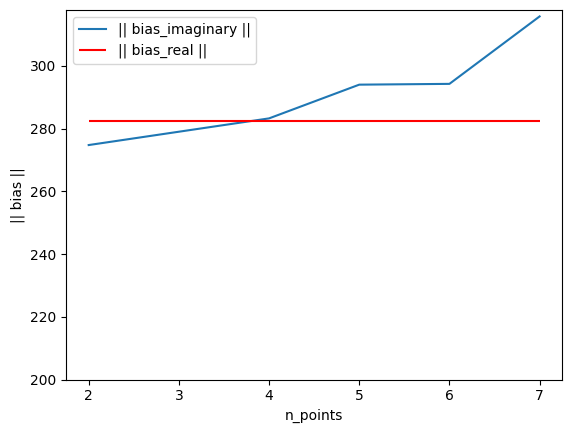

In [15]:
b_norms = [op.bias.norm().item() for op in imaginary_operators]
plt.plot(range(2, 8), b_norms, label = "|| bias_imaginary ||")
plt.hlines(operator.bias.norm().item(), 2, 7, color="red", label = "|| bias_real ||")
plt.ylim(bottom=200)
plt.legend()
plt.ylabel("|| bias ||")
plt.xlabel("n_points")

In [16]:
for sample in test.samples:
    pred = operator_i(sample.subject).predictions[:3]
    print(f"{sample} | pred: {[f'{p.token} ({p.prob:.2f})' for p in pred]}")

accountant -> office | pred: [' office (0.32)', ' accountant (0.19)', ' accounting (0.10)']
barber -> barbershop | pred: [' hair (0.29)', ' beauty (0.27)', ' dentist (0.09)']
farmer -> farm | pred: [' farm (0.42)', ' plant (0.19)', ' agriculture (0.07)']
firefighter -> fire station | pred: [' fire (0.37)', ' firefighter (0.25)', ' ambulance (0.11)']
hairdresser -> salon | pred: [' beauty (0.23)', ' store (0.13)', ' pharmacy (0.07)']
lawyer -> courthouse | pred: [' lawyer (0.41)', ' law (0.40)', ' lawyers (0.08)']
librarian -> library | pred: [' library (0.93)', ' store (0.01)', ' pharmacy (0.01)']
musician -> concert hall | pred: [' music (0.63)', ' studio (0.07)', ' concert (0.04)']
nurse -> hospital | pred: [' nursing (0.30)', ' nurses (0.28)', ' hospital (0.23)']
photographer -> studio | pred: [' studio (0.44)', ' photography (0.16)', ' photo (0.07)']
salesperson -> store | pred: [' sales (0.37)', ' retail (0.21)', ' store (0.20)']
scientist -> laboratory | pred: [' research (0.49)'